# 06. 최종 모델 평가 및 해석

**목표**: Test 데이터로 최종 평가 및 모델 해석

## 📋 작업 계획

1. 최종 모델 로드
2. Test 데이터 평가
3. Feature Importance 분석
4. 예측 오차 분석
5. 비즈니스 인사이트 도출

## 1. 라이브러리 및 데이터 로드

In [18]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Apple SD Gothic Neo'  # Mac
plt.rcParams['axes.unicode_minus'] = False

# 프로젝트 루트 경로 추가
sys.path.append('..')

from utils.evaluation import (
    evaluate_model,
    plot_actual_vs_predicted,
    plot_residuals,
    plot_feature_importance,
    analyze_prediction_errors
)

print("라이브러리 로드 완료!")

라이브러리 로드 완료!


In [19]:
# 데이터 로드
X_train = pd.read_csv('data/final/X_train.csv')
X_test = pd.read_csv('data/final/X_test.csv')

y_train = pd.read_csv('data/final/y_train.csv')['audiAcc']
y_test = pd.read_csv('data/final/y_test.csv')['audiAcc']

# 원본 데이터 (영화명 포함)
movie_features = pd.read_csv('data/processed/movie_features.csv')

print("데이터 로드 완료!")

데이터 로드 완료!


In [20]:
# 최종 모델 로드
best_model = joblib.load('models/best_model.pkl')

print(f"최종 모델 로드 완료: {type(best_model).__name__}")

최종 모델 로드 완료: LGBMRegressor


## 2. Test 데이터 최종 평가

In [21]:
# Test 예측
y_test_pred = best_model.predict(X_test)

# 최종 평가
test_metrics = evaluate_model(
    y_test,
    y_test_pred,
    model_name=f'{type(best_model).__name__} (Test Set)'
)


=== LGBMRegressor (Test Set) Performance ===
RMSE: 1,136,763 명
MAE: 337,351 명
R²: 0.524
MAPE: 409.59%


In [22]:
# Train/Test 성능 비교
y_train_pred = best_model.predict(X_train)
train_metrics = evaluate_model(y_train, y_train_pred, model_name='Train Set')

print("\n=== Train vs Test 성능 비교 ===")
print(f"Train R²: {train_metrics['R2']:.3f}")
print(f"Test R²:  {test_metrics['R2']:.3f}")
print(f"차이:     {abs(train_metrics['R2'] - test_metrics['R2']):.3f}")


=== Train Set Performance ===
RMSE: 505,878 명
MAE: 170,659 명
R²: 0.885
MAPE: 365.03%

=== Train vs Test 성능 비교 ===
Train R²: 0.885
Test R²:  0.524
차이:     0.361


## 3. 예측 결과 시각화

### 3.1 실제값 vs 예측값

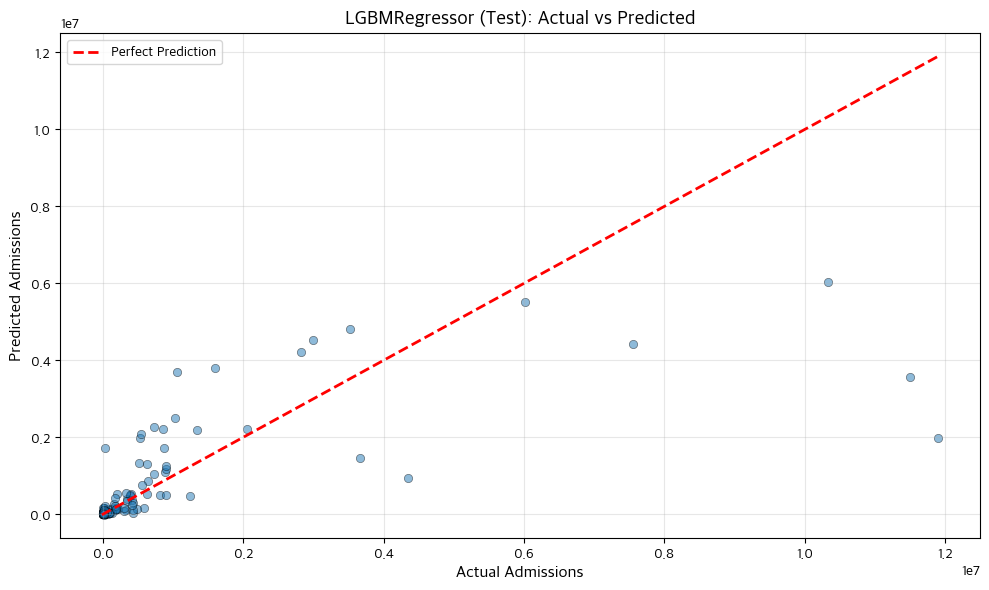

In [23]:
# Test set 시각화
plot_actual_vs_predicted(
    y_test,
    y_test_pred,
    model_name=f'{type(best_model).__name__} (Test)'
)

### 3.2 잔차 분석

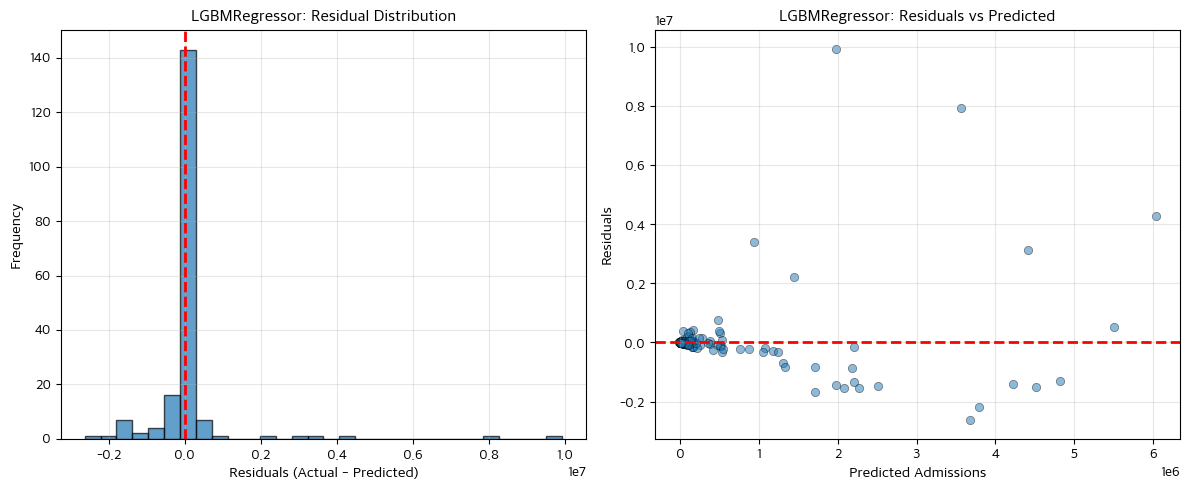

In [24]:
# 잔차 시각화
plot_residuals(
    y_test,
    y_test_pred,
    model_name=f'{type(best_model).__name__}'
)

## 4. Feature Importance 분석

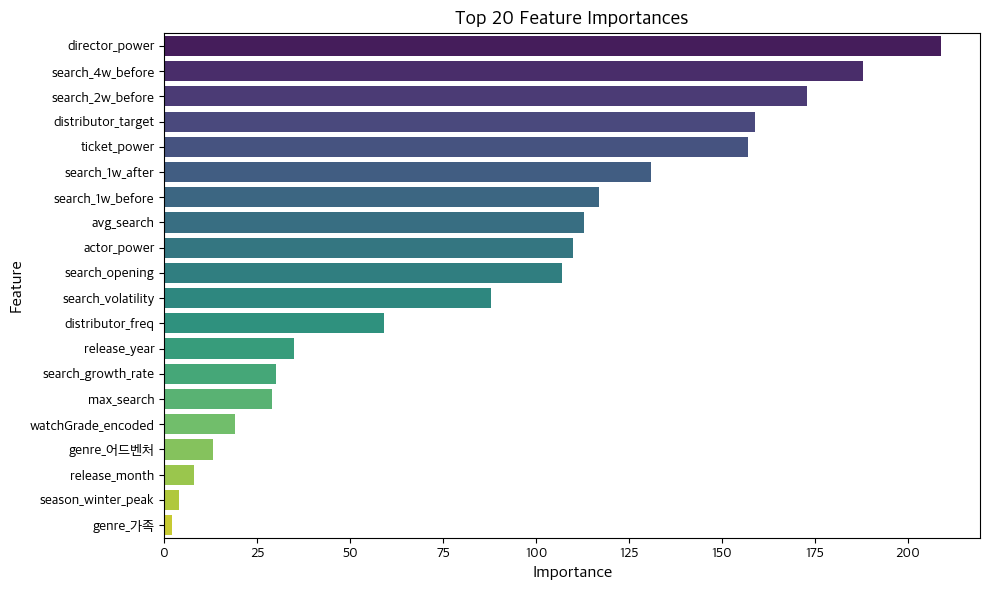


=== Top 20 중요 Feature ===
               feature  importance
9       director_power         209
0     search_4w_before         188
1     search_2w_before         173
44  distributor_target         159
11        ticket_power         157
4      search_1w_after         131
2     search_1w_before         117
6           avg_search         113
10         actor_power         110
3       search_opening         107
7    search_volatility          88
43    distributor_freq          59
36        release_year          35
8   search_growth_rate          30
5           max_search          29
45  watchGrade_encoded          19
13          genre_어드벤처          13
34       release_month           8
42  season_winter_peak           4
32            genre_가족           2

Feature Importance 저장 완료: results/feature_importance.csv


In [25]:
# Feature Importance (Tree 기반 모델인 경우)
if hasattr(best_model, 'feature_importances_'):
    feature_importance_df = plot_feature_importance(
        best_model,
        X_train.columns.tolist(),
        top_n=20
    )
    
    print("\n=== Top 20 중요 Feature ===")
    print(feature_importance_df.head(20))
    
    # Feature Importance 저장
    feature_importance_df.to_csv('results/feature_importance.csv', index=False)
    print("\nFeature Importance 저장 완료: results/feature_importance.csv")
else:
    print("이 모델은 feature_importances_를 제공하지 않습니다.")
    
    # Linear 모델의 경우 계수 확인
    if hasattr(best_model, 'coef_'):
        coef_df = pd.DataFrame({
            'feature': X_train.columns,
            'coefficient': best_model.coef_,
            'abs_coefficient': np.abs(best_model.coef_)
        }).sort_values('abs_coefficient', ascending=False)
        
        print("\n=== Top 20 중요 Feature (계수 기준) ===")
        print(coef_df.head(20))

## 5. 예측 오차 분석

### 5.1 오차가 큰 영화 분석

In [26]:
# Test 세트의 인덱스로 영화명 매칭
# (실제 프로젝트에서는 인덱스 매칭 로직 필요)

error_df = analyze_prediction_errors(
    y_test.values,
    y_test_pred,
    movie_names=None,  # 영화명이 있다면 전달
    top_n=10
)


=== Top 10 Movies with Largest Prediction Errors ===
       actual     predicted         error  error_percentage
175  11902097  1.974005e+06  9.928092e+06         83.414644
114  11495435  3.559785e+06  7.935650e+06         69.033054
35   10324794  6.037377e+06  4.287417e+06         41.525444
112   4346803  9.423926e+05  3.404410e+06         78.319868
18    7545831  4.413513e+06  3.132318e+06         41.510573
144   1054518  3.682883e+06  2.628365e+06        249.248031
125   3657537  1.450382e+06  2.207155e+06         60.345383
25    1600701  3.787483e+06  2.186782e+06        136.614016
149     21116  1.711426e+06  1.690310e+06       8004.877386
22     546121  2.085290e+06  1.539169e+06        281.836634


### 5.2 오차 패턴 분석

=== 예측 패턴 분석 ===
과대 예측: 127 건 (67.6%)
과소 예측: 61 건 (32.4%)


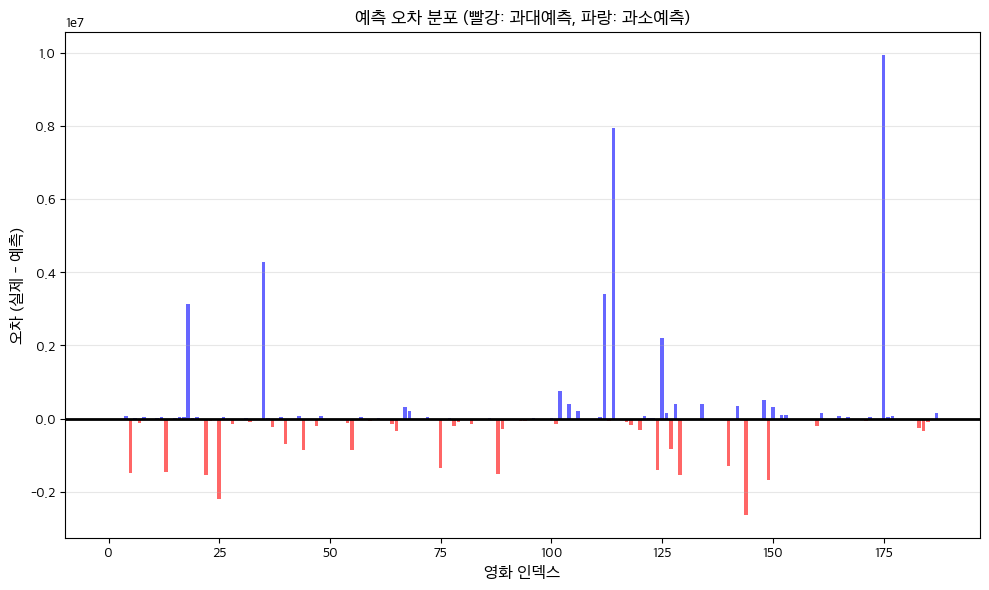

In [27]:
# 과대/과소 예측 분석
errors = y_test - y_test_pred

overestimated = (errors < 0).sum()  # 예측 > 실제
underestimated = (errors > 0).sum()  # 예측 < 실제

print("=== 예측 패턴 분석 ===")
print(f"과대 예측: {overestimated} 건 ({overestimated/len(errors)*100:.1f}%)")
print(f"과소 예측: {underestimated} 건 ({underestimated/len(errors)*100:.1f}%)")

# 시각화
plt.figure(figsize=(10, 6))
colors = ['red' if e < 0 else 'blue' for e in errors]
plt.bar(range(len(errors)), errors, color=colors, alpha=0.6)
plt.axhline(0, color='black', linewidth=2)
plt.xlabel('영화 인덱스', fontsize=12)
plt.ylabel('오차 (실제 - 예측)', fontsize=12)
plt.title('예측 오차 분포 (빨강: 과대예측, 파랑: 과소예측)', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 5.3 관객수 구간별 성능

=== 관객수 구간별 성능 (MAPE) ===
     segment  count        mape
0       ~10만    127  572.719038
1    10만~50만     28   50.322947
2   50만~100만     17   98.583349
3  100만~500만     11   85.379809
4      500만~      5   48.795132


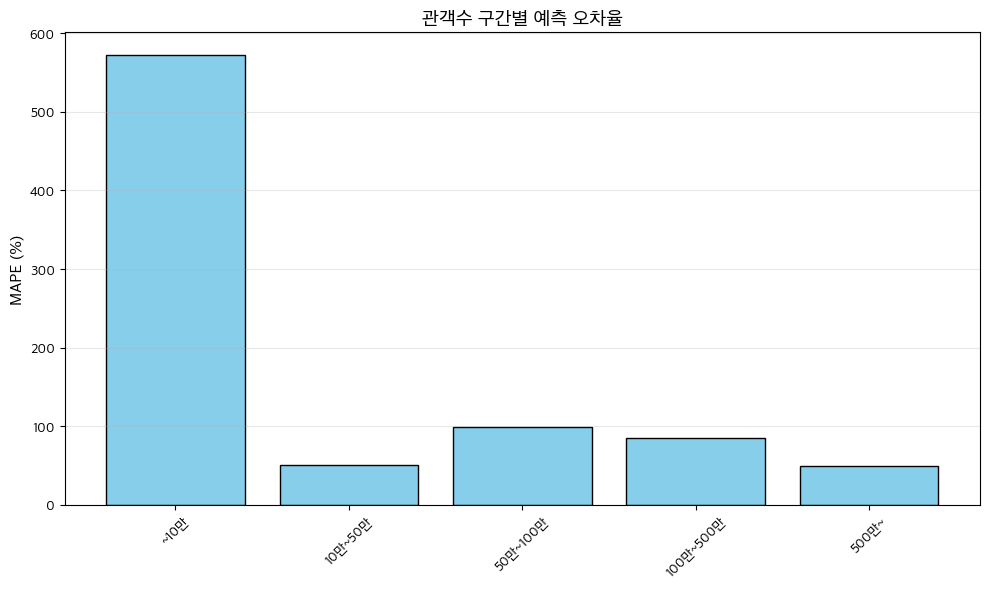

In [28]:
# 관객수를 구간으로 나누어 성능 비교
bins = [0, 100000, 500000, 1000000, 5000000, float('inf')]
labels = ['~10만', '10만~50만', '50만~100만', '100만~500만', '500만~']

test_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_test_pred,
    'segment': pd.cut(y_test.values, bins=bins, labels=labels)
})

# 구간별 MAPE 계산
segment_performance = []
for segment in labels:
    segment_data = test_df[test_df['segment'] == segment]
    if len(segment_data) > 0:
        mape = np.mean(np.abs((segment_data['actual'] - segment_data['predicted']) / segment_data['actual'])) * 100
        segment_performance.append({
            'segment': segment,
            'count': len(segment_data),
            'mape': mape
        })

segment_df = pd.DataFrame(segment_performance)

print("=== 관객수 구간별 성능 (MAPE) ===")
print(segment_df)

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(len(segment_df)), segment_df['mape'], color='skyblue', edgecolor='black')
plt.xticks(range(len(segment_df)), segment_df['segment'], rotation=45)
plt.ylabel('MAPE (%)', fontsize=12)
plt.title('관객수 구간별 예측 오차율', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 6. 핵심 인사이트 도출

In [29]:
print("\n" + "="*60)
print("핵심 인사이트")
print("="*60)

if hasattr(best_model, 'feature_importances_'):
    top_5_features = feature_importance_df.head(5)['feature'].tolist()
    
    print("\n🔑 흥행 예측의 핵심 요인 (Top 5)")
    for i, feature in enumerate(top_5_features, 1):
        importance = feature_importance_df[feature_importance_df['feature'] == feature]['importance'].values[0]
        print(f"  {i}. {feature} (중요도: {importance:.3f})")
    
    print("\n💡 인사이트")
    
    # 검색량 관련 Feature가 많은지 확인
    search_features = [f for f in top_5_features if 'search' in f.lower()]
    if search_features:
        print(f"  - 검색 트렌드가 중요한 예측 변수임 ({len(search_features)}/5)")
        print("    → 개봉 전 온라인 관심도가 흥행을 좌우")
    
    # Ticket Power 확인
    power_features = [f for f in top_5_features if 'power' in f.lower()]
    if power_features:
        print(f"  - Ticket Power가 유의미한 변수 ({len(power_features)}/5)")
        print("    → 감독/배우의 과거 성적이 영향력 있음")
    
    # 장르 확인
    genre_features = [f for f in top_5_features if 'genre' in f.lower()]
    if genre_features:
        print(f"  - 특정 장르가 중요 ({len(genre_features)}/5)")
        print(f"    → 주요 장르: {', '.join(genre_features)}")

print("\n📊 모델 성능")
print(f"  - Test R²: {test_metrics['R2']:.3f}")
print(f"    → 관객수 변동의 {test_metrics['R2']*100:.1f}%를 설명")
print(f"  - Test MAPE: {test_metrics['MAPE']:.1f}%")
print(f"    → 평균적으로 {test_metrics['MAPE']:.1f}% 오차")

print("\n" + "="*60)


핵심 인사이트

🔑 흥행 예측의 핵심 요인 (Top 5)
  1. director_power (중요도: 209.000)
  2. search_4w_before (중요도: 188.000)
  3. search_2w_before (중요도: 173.000)
  4. distributor_target (중요도: 159.000)
  5. ticket_power (중요도: 157.000)

💡 인사이트
  - 검색 트렌드가 중요한 예측 변수임 (2/5)
    → 개봉 전 온라인 관심도가 흥행을 좌우
  - Ticket Power가 유의미한 변수 (2/5)
    → 감독/배우의 과거 성적이 영향력 있음

📊 모델 성능
  - Test R²: 0.524
    → 관객수 변동의 52.4%를 설명
  - Test MAPE: 409.6%
    → 평균적으로 409.6% 오차



## 7. 비즈니스 가치

In [30]:
print("=== 비즈니스 활용 방안 ===")
print("\n1️⃣ 마케팅 예산 최적화")
print("   - 개봉 2주 전 검색량이 낮은 경우")
print("     → 온라인 마케팅 강화 필요")
print("   - 예상 관객수 기반 마케팅 예산 배분")

print("\n2️⃣ 투자 의사결정 지원")
print("   - 기획 단계에서 흥행 가능성 사전 평가")
print("   - 감독/배우 캐스팅의 영향력 정량화")

print("\n3️⃣ 리스크 관리")
print("   - 흥행 실패 위험 조기 감지")
print("   - 시나리오별 수익 시뮬레이션")

print("\n4️⃣ 개봉 시기 결정")
print("   - 시즌별/월별 효과 반영")
print("   - 경쟁작 회피 전략 수립")

=== 비즈니스 활용 방안 ===

1️⃣ 마케팅 예산 최적화
   - 개봉 2주 전 검색량이 낮은 경우
     → 온라인 마케팅 강화 필요
   - 예상 관객수 기반 마케팅 예산 배분

2️⃣ 투자 의사결정 지원
   - 기획 단계에서 흥행 가능성 사전 평가
   - 감독/배우 캐스팅의 영향력 정량화

3️⃣ 리스크 관리
   - 흥행 실패 위험 조기 감지
   - 시나리오별 수익 시뮬레이션

4️⃣ 개봉 시기 결정
   - 시즌별/월별 효과 반영
   - 경쟁작 회피 전략 수립


## 8. 최종 평가 요약

In [31]:
print("\n" + "="*60)
print("최종 모델 평가 요약")
print("="*60)

print(f"\n🎯 모델: {type(best_model).__name__}")

print("\n📈 Test Set 성능")
print(f"  RMSE: {test_metrics['RMSE']:,.0f} 명")
print(f"  MAE:  {test_metrics['MAE']:,.0f} 명")
print(f"  R²:   {test_metrics['R2']:.3f}")
print(f"  MAPE: {test_metrics['MAPE']:.2f}%")

print("\n✅ 프로젝트 목표 달성 여부")
if test_metrics['R2'] > 0.7:
    print("  🌟 목표 초과 달성! (R² > 0.7)")
elif test_metrics['R2'] > 0.5:
    print("  ✅ 목표 달성! (R² > 0.5)")
else:
    print("  ⚠️ 개선 여지 있음")

print("\n" + "="*60)
print("✅ 모델 평가 및 해석 완료!")
print("다음 단계: 07_final_report.ipynb")
print("="*60)


최종 모델 평가 요약

🎯 모델: LGBMRegressor

📈 Test Set 성능
  RMSE: 1,136,763 명
  MAE:  337,351 명
  R²:   0.524
  MAPE: 409.59%

✅ 프로젝트 목표 달성 여부
  ✅ 목표 달성! (R² > 0.5)

✅ 모델 평가 및 해석 완료!
다음 단계: 07_final_report.ipynb
